In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
y

array([0., 0., 0., ..., 9., 9., 9.])

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

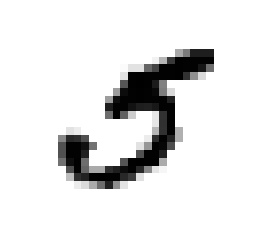

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [8]:
y[36000]

5.0

MNIST数据集前60000个是训练集，后10000个是测试集（已经分好）：

In [9]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [10]:
import numpy as np

In [11]:
# 打乱训练集，确保CV时所有的folds都差不多
shuffle_idx = np.random.permutation(60000)
X_train, y_train = X[shuffle_idx], y[shuffle_idx]

## 二分类

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
y_train_5

array([False, False, False, ..., False, False, False])

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.base import clone

In [17]:
clone_clf = clone(sgd_clf)

In [18]:
clone_clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [19]:
sgd_clf.intercept_

array([126.76495537])

In [20]:
clone_clf.intercept_

AttributeError: 'SGDClassifier' object has no attribute 'intercept_'

只使用相同的参数。

## 性能考核

### 使用交叉验证精度测量准确率

In [21]:
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,
                scoring='accuracy', n_jobs=-1)

array([0.9666 , 0.96325, 0.9663 ])

或者这样：

In [24]:
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [26]:
for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train_5[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_test_folds))

0.9666
0.96325
0.9663


### 笨分类器

+ dummy clf

In [27]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train,
                                                               y_train_5)
pred_most_frequent = dummy_majority.predict(X_test)
print('Unique predicted labels: {}'.format(np.unique(pred_most_frequent)))
print('Test score: {}'.format(dummy_majority.score(X_test, y_test_5)))

Unique predicted labels: [False]
Test score: 0.9108


+ 自定以分类器

In [28]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    '''将每张图都分为非5.'''
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90775, 0.91045, 0.91075])

全部预测为非5的accuracy超过90%，这是因为大约只有10%的图像是数字5。**正确率通常无法成为分类器的首要性能指标，特别是当处理类别不平衡数据集的时候。**

## 混淆矩阵（confusion matrix）

confusion matrix是评估二分类问题最全面的指标。

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53617,   962],
       [ 1115,  4306]])

行表示实际类别，列表示预测类别，主对角线对应于正确的分类，其他元素表示一个类别中有多少被误分为其他类别。

In [33]:
sgd_clf.classes_

array([False,  True])

二分类中，第一个类别表示负类（非5），第二个表示正类（5）。

### precision

$precision = \frac {TP} {TP + FP}$

正类预测的准确率。

In [32]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)

0.8173880030372058

In [35]:
4306 / (4306 + 962)

0.8173880030372058

### recall / TPR

$recall / TPR = \frac {TP}{TP + FN}$

正类样本有多少被预测为正类。

In [36]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)

0.7943183914406936

In [37]:
4306 / (4305 + 1115)

0.7944649446494465

**precision通常与recall一起使用。**

### F1

将precision和recall结合起来得到F1分数。当需要一个简单的方法来比较两种分类器时，这是非常不错的指标。只有当precision和recall都很高时，分类器才能得到较高的F1分数。

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision\times recall}{precision + recall}$

In [38]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.8056880905603891

F1分数的一个缺点是难以解释。

F1分数同时考虑了precision和recall，所以它对于不平衡的数据集来说是一种更好的度量。

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_train_5, y_train_pred))

             precision    recall  f1-score   support

      False       0.98      0.98      0.98     54579
       True       0.82      0.79      0.81      5421

avg / total       0.96      0.97      0.97     60000



support表示这个类别在数据集中数量。avg是对应指标的加权平均。

In [45]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_train_5, y_train_pred)

(array([0.97962801, 0.817388  ]),
 array([0.98237417, 0.79431839]),
 array([0.98099917, 0.80568809]),
 array([54579,  5421]))

### precision / recall权衡

提高threshold，precision提高，recall降低，

降低threshold，precision降低，recall提高。

`decision_function()`的threshold为0，`predict_proba()`的threshold为0.5。

In [44]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function', n_jobs=-1)

In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [47]:
len(precisions)

59958

In [48]:
len(thresholds)

59957

In [49]:
len(recalls)

59958

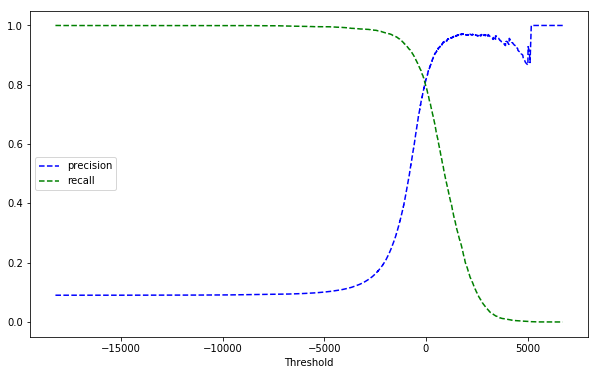

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label='recall')
plt.xlabel('Threshold')
plt.legend(loc='center left')
plt.show()

> threshold增大，recall只会降低（曲线较平滑），但precision有时可能会降低（图中曲线崎岖原因）。

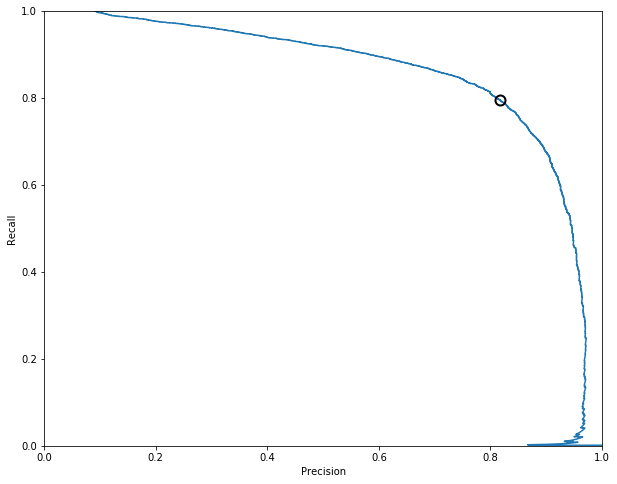

In [56]:
close_zero = np.argmin(np.abs(thresholds))  # 最接近0的threshold

plt.figure(figsize=(10, 8))
plt.plot(precisions, recalls, label='precision recall curve')
plt.plot(precisions[close_zero], recalls[close_zero], 'o', markersize=10,
         label='threshold 0', fillstyle='none', c='k', mew=2)
plt.xlabel('Precision')
plt.xlim(0, 1)
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.show()

**曲线越靠近右上角，分类器越好**。右上角的点表示同一threshold，precision和recall都很高。随着precision的升高模型能够保持较高的recall，则模型越好。

曲线从左上角开始，这里对应非常低的阈值，所有样本都被划为正类。

总结precision-recall曲线的一种方法是计算该曲线下的积分或面积，叫作**平均准确率（average precision）。**

因为要计算precision-recall曲线并考虑多个阈值，所以需要向`metrics.average_precision_score()`传入`decision_function()`或`predict_proba()`的结果，而不是`predict()`的值。

$AP=\sum_{n}({R_n - R_{n-1})P_n}$

In [57]:
from sklearn.metrics import average_precision_score

y_test_pred = sgd_clf.decision_function(X_test)
average_precision_score(y_test_5, y_test_pred)

0.8945955517512664

AP是曲线下的面积，所以总是从0（最差）到1（最好）之间的值。**只适用于二分类或多类别分类任务。**

### ROC（受试工作者特征）与AUC

ROC与precision-recall曲线非常相似，考虑了给定分类器所有可能的threshold，但绘制的是假正例率（false true rate，FTR）和真正例率（true positive rate，TPR）。**只能二分类。**

$TPR = \frac{TP}{TP+FN}$, $FPR=\frac{FP}{FP+TN}$

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [59]:
len(fpr)

3187

In [60]:
len(tpr)

3187

In [61]:
len(thresholds)

3187

In [63]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')

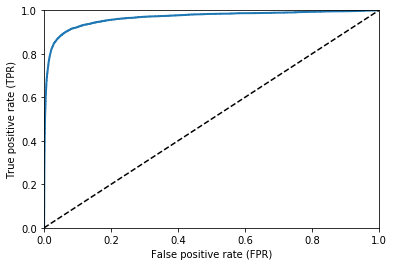

In [64]:
plot_roc_curve(fpr, tpr)
plt.show()

召回率TPR越高，分类器产生的假正类（FPR）就越多。虚线表示纯随机分类器的ROC曲线：一个优秀的分类器应该离这条线越远越好（向左上角）。

**另一个比较分类器的方法:测量曲线下面积。**完美的分类器ROC AUC等于1，而随机分类器的ROC AUC等于0.5。

In [65]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9660865196447503

**选择PR曲线或ROC曲线：当正类非常少见或者更关注假正类而不是假负类时，应该选择曲线，反之则是ROC曲线。**

本例正类（数字5）相比负类（非5）很少，PR曲线清楚地说明分类器还有改进的空间。

对于类别不平衡问题，AUC是一个比precision好得多的指标。

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas = cross_val_predict(rf_clf, X_train, y_train_5, cv=3,
                             method='predict_proba', n_jobs=-1)

绘制ROC曲线，需要的是分数而不是概率大小。一个简单的方法：直接使用正类的概率作为分数值。

In [67]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_probas[:, 1])

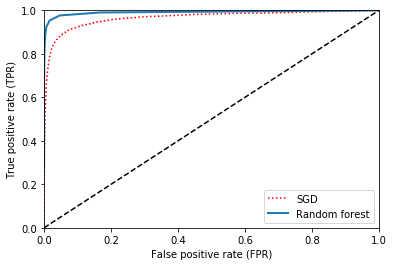

In [69]:
plt.plot(fpr, tpr, 'r:', label='SGD')
plot_roc_curve(fpr_rf, tpr_rf, 'Random forest')
plt.legend()
plt.show()

In [70]:
roc_auc_score(y_train_5, y_probas[:, 1])

0.9913147648040149

## 多类别分类器（Multiclass Clf）

随机森林分类器和朴素贝叶斯分类器可以直接处理多个类别，诸如SVM和线性分类器这些只能处理二分类。

1. OvA(one-versus-the rest)：一个类和剩余训练一个分类器，N个类需要N个训练器。
2. OvO(one-versus-one)：为每两个类训练一个二分类器，N个类需要N(N-1)/2个分类器。优点：每个分类器只要部分训练集对其必须区分的两个类别进行训练。

有些算法（SVM）在数据规模扩大时表现糟糕， 此时OVO是一个比较好的选择。但对大多数二元分类器来说，OvA策略还是更好的选择。

**Sklearn可以检测到你尝试使用二分类算法进行多类别分类任务，它会自动运行OvA（SVM除外，它会使用OVO）。**

In [71]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

在内部，实际上训练了10个二分类器，获得decision_function()，然后选择分数最高的。

In [72]:
sgd_clf.predict([some_digit])

array([5.])

In [73]:
sgd_clf.decision_function([some_digit])

array([[  -79.10158778, -4153.97487182, -1517.7133887 ,   -98.07380496,
        -2362.85496129,   621.97371014, -3489.37529079, -3734.77518705,
        -3647.90021494, -4142.68748316]])

**可以强行选择OvO或者OvA，只要使用`OneVsOneClassifier`或`OneVsRestClassifier`。**

In [74]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=500),
                             n_jobs=-1)
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=500, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=-1)

In [75]:
ovo_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [76]:
len(ovo_clf.estimators_)

45

In [78]:
ovo_clf.decision_function([some_digit])

array([[7.19834256, 2.89665873, 5.15087892, 8.26152555, 2.89443228,
        9.5       , 0.5627846 , 4.97382132, 1.80245752, 1.75909851]])

RF可以直接处理多类别：

In [77]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [79]:
rf_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0.1]])

In [81]:
ovo_clf.score(X_test, y_test)

0.9191

SGD需要预处理：

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
x_test_scaled = scaler.transform(X_test.astype(np.float64))

In [84]:
ovo_clf.fit(X_train_scaled, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=500, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=-1)

In [85]:
ovo_clf.score(x_test_scaled, y_test)

0.9237

### 错误分析

In [86]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)

In [87]:
confusion_mat = confusion_matrix(y_train, y_train_pred)
confusion_mat

array([[5611,    0,   14,    7,    8,   45,   31,    7,  199,    1],
       [   1, 6426,   44,   24,    3,   41,    4,    8,  179,   12],
       [  22,   25, 5268,   88,   67,   26,   66,   43,  344,    9],
       [  27,   18,  118, 5279,    1,  190,   23,   46,  364,   65],
       [  13,   12,   47,   11, 5233,    9,   35,   27,  304,  151],
       [  33,   17,   26,  164,   53, 4474,   81,   18,  486,   69],
       [  29,   18,   46,    1,   39,   87, 5559,    9,  129,    1],
       [  22,   15,   53,   23,   51,   11,    3, 5741,  144,  202],
       [  14,   64,   40,   99,    2,  123,   31,   10, 5423,   45],
       [  21,   21,   23,   60,  127,   37,    1,  173,  323, 5163]])

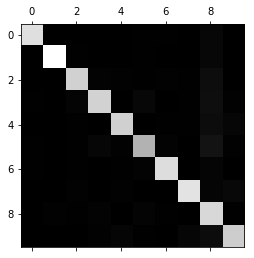

In [88]:
plt.matshow(confusion_mat, cmap=plt.cm.gray)
plt.show()

将confusion matrix中的每个值除以相应类别中的图片数量，这样比较的就是错误了而不是错误的绝对值（后者对于图片数量的类别不公平）。

In [90]:
row_sums = confusion_mat.sum(axis=1, keepdims=True)
norm_confusion_mat = confusion_mat / row_sums

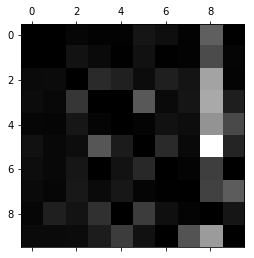

In [91]:
# 用0填充对角线，只保留错误，重新绘制出结果
np.fill_diagonal(norm_confusion_mat, 0)
plt.matshow(norm_confusion_mat, cmap=plt.cm.gray)
plt.show()

In [93]:
print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        0.0       0.97      0.95      0.96      5923
        1.0       0.97      0.95      0.96      6742
        2.0       0.93      0.88      0.91      5958
        3.0       0.92      0.86      0.89      6131
        4.0       0.94      0.90      0.92      5842
        5.0       0.89      0.83      0.86      5421
        6.0       0.95      0.94      0.95      5918
        7.0       0.94      0.92      0.93      6265
        8.0       0.69      0.93      0.79      5851
        9.0       0.90      0.87      0.89      5949

avg / total       0.91      0.90      0.90     60000



**对于多类别的不平衡数据集，最常用的指标是多分类版本的f1分数。**多分类f1分数思想是，对每个类别计算一个二分类f1分数，其中该类别是正类，其他所有类别组成反类。然后，使用一下策略之一对这些按类别f1分数进行平均：
+ 宏平均（macro）：计算未加权的按类别f1分数。对所有类别给出相同权重，无论类别中的样本量大小。
+ 加权平均（weighted）：以每个类别的支持作为权重来计算按类别f1分数的平均值。
+ 微平均（micro）：计算所有类别中假正例、假反例和真正例的总数，然后利用这些计数来计算precision、recall和f1-score。

In [94]:
f1_score(y_train, y_train_pred, average='micro')

0.90295

In [95]:
f1_score(y_train, y_train_pred, average='macro')

0.9034728308017673

## 多标签分类Multilabel Clf

每个样本可以分为多个类别。

In [96]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [97]:
y_multilabel

array([[False, False],
       [ True,  True],
       [False,  True],
       ...,
       [False, False],
       [False,  True],
       [ True, False]])

In [98]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [99]:
knn_clf.predict([some_digit])

array([[False,  True]])

## 多输出分类（Multioutput Clf）

## 回归（regression）

对大多数情况，使用默认的$R^2$足够了。它由所有回归器的`score()`方法给出。或者使用MSE，RMES，MAE等。

在使用`GridSearchCV`或者`cross_val_score()`可以通过参数`scoring`来指定想用的指标。

In [101]:
from sklearn.metrics.scorer import SCORERS
print("Average scorers:\n{}".format(SCORERS.keys()))

Average scorers:
dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'median_absolute_error', 'mean_absolute_error', 'mean_squared_error', 'accuracy', 'roc_auc', 'average_precision', 'log_loss', 'neg_log_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])
